In [1]:
import time
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

### Using Monte-Carlo method for finding optimal Sharpe ratios in cryptocurrency portfolios

First, we'll use the yahoo finance API to get stock price data for four coins--bitcoin, ethereum, litecoin, and ripple

In [5]:
stocks = ['DASH-USD', 'XMR-USD', 'ETC-USD', 'LTC-USD',
         'EOS-USD', 'XRP-USD', 'TRX-USD']

In [3]:
def get_data(tickers, start_date, end_date):
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    
    # download daily price data for each of the stocks in the portfolio
    df = pdr.get_data_yahoo(stocks, start=start_date, end = end_date)['Adj Close']
    df.sort_index(inplace = True)
    
    return df

In [6]:
today = '2021-10-18'
stockStartDate = '2018-10-18'
crypto_prices = get_data(stocks, stockStartDate, today)
print(crypto_prices.head())

Symbols       DASH-USD     XMR-USD  ETC-USD    LTC-USD  EOS-USD   XRP-USD  \
Date                                                                        
2018-10-17  154.820007  102.913002  9.59396  52.526901  5.35464  0.457725   
2018-10-18  152.899002  103.723000  9.59793  53.020100  5.33373  0.454178   
2018-10-19  154.772995  103.778999  9.68825  53.362801  5.37239  0.459151   
2018-10-20  154.563004  105.099998  9.64013  52.915798  5.42305  0.456694   
2018-10-21  151.723999  105.459999  9.99823  52.203899  5.38301  0.453109   

Symbols      TRX-USD  
Date                  
2018-10-17  0.024271  
2018-10-18  0.024074  
2018-10-19  0.024157  
2018-10-20  0.024196  
2018-10-21  0.023811  


#### Next, we'll define a function for calculating daily returns for our coins

In [7]:
def calc_daily_returns(df):
    return (df.pct_change())

In [8]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

Symbols     DASH-USD   XMR-USD   ETC-USD   LTC-USD   EOS-USD   XRP-USD  \
Date                                                                     
2018-10-17       NaN       NaN       NaN       NaN       NaN       NaN   
2018-10-18 -0.012408  0.007871  0.000414  0.009389 -0.003905 -0.007749   
2018-10-19  0.012256  0.000540  0.009410  0.006464  0.007248  0.010949   
2018-10-20 -0.001357  0.012729 -0.004967 -0.008377  0.009430 -0.005351   
2018-10-21 -0.018368  0.003425  0.037147 -0.013453 -0.007383 -0.007850   

Symbols      TRX-USD  
Date                  
2018-10-17       NaN  
2018-10-18 -0.008117  
2018-10-19  0.003448  
2018-10-20  0.001614  
2018-10-21 -0.015912  


#### Define a function for calculating mean daily returns for our coins

In [9]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [11]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets)

Symbols
DASH-USD    0.002052
XMR-USD     0.002235
ETC-USD     0.003483
LTC-USD     0.002664
EOS-USD     0.001782
XRP-USD     0.002676
TRX-USD     0.002955
dtype: float64


#### Define a function for creating covariance matrices

In [12]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [13]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

Symbols   DASH-USD   XMR-USD   ETC-USD   LTC-USD   EOS-USD   XRP-USD   TRX-USD
Symbols                                                                       
DASH-USD  0.003827  0.002302  0.002779  0.002366  0.002696  0.002122  0.002204
XMR-USD   0.002302  0.002693  0.002073  0.002039  0.002149  0.001784  0.001907
ETC-USD   0.002779  0.002073  0.003906  0.002432  0.002869  0.002153  0.002322
LTC-USD   0.002366  0.002039  0.002432  0.002921  0.002693  0.002150  0.002142
EOS-USD   0.002696  0.002149  0.002869  0.002693  0.003884  0.002589  0.002576
XRP-USD   0.002122  0.001784  0.002153  0.002150  0.002589  0.003867  0.002239
TRX-USD   0.002204  0.001907  0.002322  0.002142  0.002576  0.002239  0.003311


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins

In [23]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(7))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2], tickers[3], tickers[4],
                                                      tickers[5], tickers[6]])
    
    return results_df

In [24]:
crypto_results = create_results_dataframe(stocks, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe  DASH-USD   XMR-USD   ETC-USD   LTC-USD  \
0  0.690055  0.797821  0.847503  0.093917  0.032060  0.189383  0.258604   
1  0.626850  0.788644  0.777220  0.056652  0.254638  0.119197  0.030594   
2  0.631279  0.793684  0.777865  0.165403  0.175833  0.157140  0.111735   
3  0.632995  0.806207  0.767911  0.120425  0.151947  0.153834  0.114849   
4  0.628342  0.793280  0.774559  0.211050  0.133133  0.093229  0.119405   

    EOS-USD   XRP-USD   TRX-USD  
0  0.084423  0.124149  0.217464  
1  0.219850  0.104537  0.214531  
2  0.156826  0.145110  0.087954  
3  0.231464  0.004704  0.222777  
4  0.136409  0.106087  0.200687  


#### Define a function to find the portfolio with the highest sharpe ratio 

In [25]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [26]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret         0.742947
stdev       0.802288
sharpe      0.908709
DASH-USD    0.009628
XMR-USD     0.131202
ETC-USD     0.354060
LTC-USD     0.231902
EOS-USD     0.015440
XRP-USD     0.018430
TRX-USD     0.239337
Name: 583, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [27]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [35]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret         0.636597
stdev       0.761575
sharpe      0.817644
DASH-USD    0.112427
XMR-USD     0.329594
ETC-USD     0.015884
LTC-USD     0.141152
EOS-USD     0.008689
XRP-USD     0.168564
TRX-USD     0.223689
Name: 946, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with teh highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [32]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    #ax.set_facecolor('4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  after removing the cwd from sys.path.


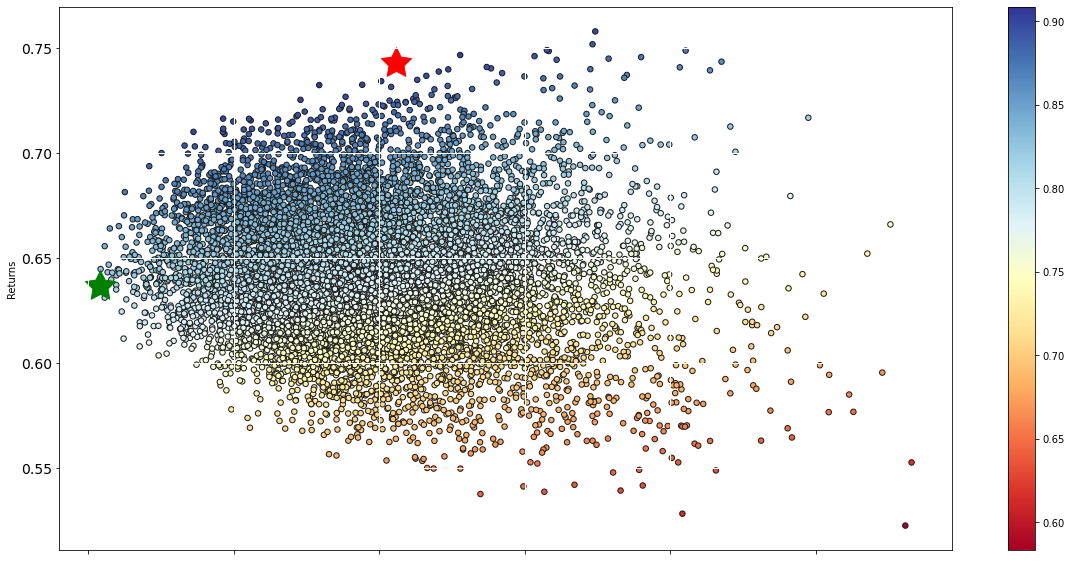

In [33]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()